# N-Gram Language Modeling and Evaluation

## 1. Overview and Objectives
Implement and evaluate various N-gram Language Models (LMs) to understand the trade-offs between different N-gram orders, and the critical role of smoothing and backoff techniques in handling data sparsity.

- Implement MLE N-gram models (N=1,2,3,4)
- Implement Add-1 (Laplace) smoothing, Linear Interpolation, and Stupid Backoff for trigrams
- Evaluate all models using Perplexity (PP) on the test set
- Analyze and discuss results
- Generate text from the best model

---

## 2. Dataset
- **Source:** [Penn Treebank Dataset](https://www.kaggle.com/datasets/aliakay8/penn-treebank-dataset)
- **Files:**
  - `ptb.train.txt` (Training)
  - `ptb.valid.txt` (Validation/Dev)
  - `ptb.test.txt` (Test)

---

## 3. Data Loading and Preprocessing

Load the Penn Treebank dataset, tokenize the text, handle sentence boundaries, and build the vocabulary.

In [ ]:
# Data paths and reproducibility setup
import os, random

# Project-relative paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
REPORTS_DIR = os.path.join(BASE_DIR, 'reports')
os.makedirs(REPORTS_DIR, exist_ok=True)

# Helper: safe join
def pjoin(*x): return os.path.join(*x)

# Default corpus paths (adjust your existing variables to use these)
train_path = pjoin(DATA_DIR, 'ptb.train.txt')
valid_path = pjoin(DATA_DIR, 'ptb.valid.txt')
test_path  = pjoin(DATA_DIR, 'ptb.test.txt')

# Fallback tiny corpus so the notebook runs even without downloads
FALLBACK_SENTENCES = [
    "the cat sat on the mat",
    "the dog chased the cat",
    "the dog sat",
    "the cat slept",
    "the dog slept on the mat"
]

In [ ]:
# Load the Penn Treebank dataset
from collections import Counter

# File paths
train_path = os.path.join('ptbdataset', 'ptb.train.txt')
valid_path = os.path.join('ptbdataset', 'ptb.valid.txt')
test_path  = os.path.join('ptbdataset', 'ptb.test.txt')

# Read data
def read_lines(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return [line.strip() for line in f if line.strip()]
    return None

train_lines = read_lines(train_path)
valid_lines = read_lines(valid_path)
test_lines  = read_lines(test_path)

if train_lines is None or valid_lines is None or test_lines is None:
    print("⚠️ PTB not found in data/. Using fallback toy corpus.")
    train_lines = FALLBACK_SENTENCES * 50  # small expansion for counts
    valid_lines = FALLBACK_SENTENCES[:]
    test_lines  = FALLBACK_SENTENCES[:]


print(f"Train: {len(train_sentences)} sentences")
print(f"Valid: {len(valid_sentences)} sentences")
print(f"Test:  {len(test_sentences)} sentences")

Train: 42068 sentences
Valid: 3370 sentences
Test:  3761 sentences


In [98]:
# Tokenization and Vocabulary
import re

def tokenize(sentence):
    # Simple whitespace tokenizer; can be replaced with more advanced if needed
    return sentence.split()

# Add sentence boundary tokens
def add_sentence_tokens(tokens):
    return ['<s>'] + tokens + ['</s>']

# Build vocabulary from training data
def build_vocab(sentences, min_freq=1):
    counter = Counter()
    for sent in sentences:
        tokens = tokenize(sent)
        counter.update(tokens)
    vocab = {w for w, c in counter.items() if c >= min_freq}
    vocab.add('<unk>')
    vocab.add('<s>')
    vocab.add('</s>')
    return vocab, counter

# Tokenize and add boundaries
train_tokens = [add_sentence_tokens(tokenize(s)) for s in train_sentences]
valid_tokens = [add_sentence_tokens(tokenize(s)) for s in valid_sentences]
test_tokens  = [add_sentence_tokens(tokenize(s)) for s in test_sentences]

# Build vocabulary (words with freq >= 1)
vocab, word_counts = build_vocab(train_sentences, min_freq=1)
print(f"Vocab size: {len(vocab)}")


Vocab size: 10001


## 4. N-Gram Model Implementation

Implement a general N-gram model class that supports MLE estimation for any N. This will be used for N=1 (unigram), N=2 (bigram), N=3 (trigram), and N=4 (4-gram) models.

In [99]:
from collections import defaultdict
import math

class NGramModel:
    def __init__(self, n, train_data, vocab):
        self.n = n
        self.vocab = vocab
        self.ngram_counts = defaultdict(int)
        self.context_counts = defaultdict(int)
        self.train(train_data)

    def train(self, data):
        for sent in data:
            tokens = [w if w in self.vocab else '<unk>' for w in sent]
            for i in range(len(tokens) - self.n + 1):
                ngram = tuple(tokens[i:i+self.n])
                context = tuple(tokens[i:i+self.n-1]) if self.n > 1 else ()
                self.ngram_counts[ngram] += 1
                self.context_counts[context] += 1

    def ngram_prob(self, ngram):
        context = ngram[:-1] if self.n > 1 else ()
        count = self.ngram_counts[ngram]
        context_count = self.context_counts[context]
        if context_count == 0:
            return 0.0
        return count / context_count

    def sent_log_prob(self, sent):
        tokens = [w if w in self.vocab else '<unk>' for w in sent]
        log_prob = 0.0
        for i in range(len(tokens) - self.n + 1):
            ngram = tuple(tokens[i:i+self.n])
            prob = self.ngram_prob(ngram)
            if prob == 0.0:
                return float('-inf')
            log_prob += math.log(prob)
        return log_prob

    def perplexity(self, data):
        log_prob_sum = 0.0
        word_count = 0
        for sent in data:
            lp = self.sent_log_prob(sent)
            if lp == float('-inf'):
                return float('inf')
            log_prob_sum += lp
            word_count += len([w for w in sent if w != '<s>'])
        return math.exp(-log_prob_sum / word_count)

In [100]:
# Train and evaluate MLE N-gram models for N=1,2,3,4
ngram_orders = [1, 2, 3, 4]
results = {}
for n in ngram_orders:
    print(f"\nTraining {n}-gram MLE model...")
    model = NGramModel(n, train_tokens, vocab)
    ppl = model.perplexity(test_tokens)
    results[f"{n}-gram"] = ppl
    print(f"{n}-gram Test Perplexity: {ppl if ppl != float('inf') else 'INF'}")

print("\nSummary of MLE N-gram Perplexities:")
for k, v in results.items():
    print(f"{k}: {v if v != float('inf') else 'INF'}")


Training 1-gram MLE model...
1-gram Test Perplexity: 771.1554096640803

Training 2-gram MLE model...
2-gram Test Perplexity: INF

Training 3-gram MLE model...
3-gram Test Perplexity: INF

Training 4-gram MLE model...
4-gram Test Perplexity: INF

Summary of MLE N-gram Perplexities:
1-gram: 771.1554096640803
2-gram: INF
3-gram: INF
4-gram: INF


## 5. Smoothing and Backoff for Trigram Models

Implement and evaluate:
- Add-1 (Laplace) Smoothing
- Linear Interpolation
- Stupid Backoff

All models are evaluated on the test set using perplexity.

In [101]:
# Add-1 (Laplace) Smoothing for Trigram Model
class LaplaceTrigramModel(NGramModel):
    def __init__(self, train_data, vocab):
        super().__init__(3, train_data, vocab)
        self.V = len(vocab)

    def ngram_prob(self, ngram):
        context = ngram[:-1]
        count = self.ngram_counts[ngram]
        context_count = self.context_counts[context]
        return (count + 1) / (context_count + self.V)

laplace_model = LaplaceTrigramModel(train_tokens, vocab)
laplace_ppl = laplace_model.perplexity(test_tokens)
print(f"Laplace Trigram Test Perplexity: {laplace_ppl}")

Laplace Trigram Test Perplexity: 2575.2044785039666


In [102]:
# Linear Interpolation for Trigram Model
class InterpolatedTrigramModel:
    def __init__(self, train_data, vocab, lambdas):
        self.vocab = vocab
        self.lambdas = lambdas
        self.models = [NGramModel(n, train_data, vocab) for n in [1,2,3]]

    def ngram_prob(self, ngram):
        unigram = (ngram[2],)
        bigram = ngram[1:]
        trigram = ngram
        p1 = self.models[0].ngram_prob(unigram)
        p2 = self.models[1].ngram_prob(bigram)
        p3 = self.models[2].ngram_prob(trigram)
        return self.lambdas[0]*p1 + self.lambdas[1]*p2 + self.lambdas[2]*p3

    def sent_log_prob(self, sent):
        tokens = [w if w in self.vocab else '<unk>' for w in sent]
        log_prob = 0.0
        for i in range(len(tokens) - 2):
            ngram = tuple(tokens[i:i+3])
            prob = self.ngram_prob(ngram)
            if prob == 0.0:
                return float('-inf')
            log_prob += math.log(prob)
        return log_prob

    def perplexity(self, data):
        log_prob_sum = 0.0
        word_count = 0
        for sent in data:
            lp = self.sent_log_prob(sent)
            if lp == float('-inf'):
                return float('inf')
            log_prob_sum += lp
            word_count += len([w for w in sent if w != '<s>'])
        return math.exp(-log_prob_sum / word_count)

# Try three lambda combinations, tune on valid set, evaluate on test set
lambda_sets = [
    (0.1, 0.3, 0.6),
    (0.2, 0.3, 0.5),
    (0.33, 0.33, 0.34),
    (0.5, 0.3, 0.2)
]
best_ppl = float('inf')
best_lambdas = None
for lambdas in lambda_sets:
    model = InterpolatedTrigramModel(train_tokens, vocab, lambdas)
    ppl = model.perplexity(valid_tokens)
    print(f"Lambdas {lambdas} - Dev Perplexity: {ppl}")
    if ppl < best_ppl:
        best_ppl = ppl
        best_lambdas = lambdas

# Evaluate best on test set
interp_model = InterpolatedTrigramModel(train_tokens, vocab, best_lambdas)
interp_ppl = interp_model.perplexity(test_tokens)
print(f"Best Linear Interpolation Lambdas: {best_lambdas}")
print(f"Linear Interpolation Trigram Test Perplexity: {interp_ppl}")

Lambdas (0.1, 0.3, 0.6) - Dev Perplexity: 201.04566841209925
Lambdas (0.2, 0.3, 0.5) - Dev Perplexity: 176.13739652442055
Lambdas (0.33, 0.33, 0.34) - Dev Perplexity: 162.14580296113328
Lambdas (0.5, 0.3, 0.2) - Dev Perplexity: 164.85455257650537
Best Linear Interpolation Lambdas: (0.33, 0.33, 0.34)
Linear Interpolation Trigram Test Perplexity: 151.15688750057834


In [103]:
# Stupid Backoff for Trigram Model
class StupidBackoffTrigramModel:
    def __init__(self, train_data, vocab, alpha=0.4):
        self.vocab = vocab
        self.alpha = alpha
        self.models = [NGramModel(n, train_data, vocab) for n in [1,2,3]]

    def ngram_prob(self, ngram):
        trigram = ngram
        bigram = ngram[1:]
        unigram = (ngram[2],)
        p3 = self.models[2].ngram_prob(trigram)
        if p3 > 0:
            return p3
        p2 = self.models[1].ngram_prob(bigram)
        if p2 > 0:
            return self.alpha * p2
        p1 = self.models[0].ngram_prob(unigram)
        return (self.alpha ** 2) * p1

    def sent_log_prob(self, sent):
        tokens = [w if w in self.vocab else '<unk>' for w in sent]
        log_prob = 0.0
        for i in range(len(tokens) - 2):
            ngram = tuple(tokens[i:i+3])
            prob = self.ngram_prob(ngram)
            if prob == 0.0:
                return float('-inf')
            log_prob += math.log(prob)
        return log_prob

    def perplexity(self, data):
        log_prob_sum = 0.0
        word_count = 0
        for sent in data:
            lp = self.sent_log_prob(sent)
            if lp == float('-inf'):
                return float('inf')
            log_prob_sum += lp
            word_count += len([w for w in sent if w != '<s>'])
        return math.exp(-log_prob_sum / word_count)

# Try two alpha values, tune on valid set, evaluate on test set
alpha_values = [0.2, 0.4, 0.7, 0.9]
best_ppl = float('inf')
best_alpha = None
for alpha in alpha_values:
    model = StupidBackoffTrigramModel(train_tokens, vocab, alpha)
    ppl = model.perplexity(valid_tokens)
    print(f"Alpha {alpha} - Dev Perplexity: {ppl}")
    if ppl < best_ppl:
        best_ppl = ppl
        best_alpha = alpha

# Evaluate best on test set
backoff_model = StupidBackoffTrigramModel(train_tokens, vocab, best_alpha)
backoff_ppl = backoff_model.perplexity(test_tokens)
print(f"Best Stupid Backoff Alpha: {best_alpha}")
print(f"Stupid Backoff Trigram Test Perplexity: {backoff_ppl}")

Alpha 0.2 - Dev Perplexity: 268.7533099618484
Alpha 0.4 - Dev Perplexity: 158.58990737672852
Alpha 0.7 - Dev Perplexity: 103.59244217076456
Alpha 0.9 - Dev Perplexity: 85.56007228015697
Best Stupid Backoff Alpha: 0.9
Stupid Backoff Trigram Test Perplexity: 80.39281187961979


## 6. Results Summary and Visualization

Below we summarize the test set perplexity for all models and visualize the results for comparison.

In [104]:
# Collect all test set perplexities
summary = {
    'Unigram (MLE)': results['1-gram'],
    'Bigram (MLE)': results['2-gram'],
    'Trigram (MLE)': results['3-gram'],
    '4-gram (MLE)': results['4-gram'],
    'Trigram (Laplace)': laplace_ppl,
    f'Trigram (Interp, λ={best_lambdas})': interp_ppl,
    f'Trigram (Backoff, α={best_alpha})': backoff_ppl
}

# Print summary table
import pandas as pd
summary_df = pd.DataFrame(list(summary.items()), columns=['Model', 'Test Perplexity'])
summary_df['Test Perplexity'] = summary_df['Test Perplexity'].apply(lambda x: 'INF' if x == float('inf') else round(x,2))
display(summary_df)


,Model,Test Perplexity
0,Unigram (MLE),771.16
1,Bigram (MLE),INF
2,Trigram (MLE),INF
3,4-gram (MLE),INF
4,Trigram (Laplace),2575.2
5,"Trigram (Interp, λ=(0.33, 0.33, 0.34))",151.16
6,"Trigram (Backoff, α=0.9)",80.39


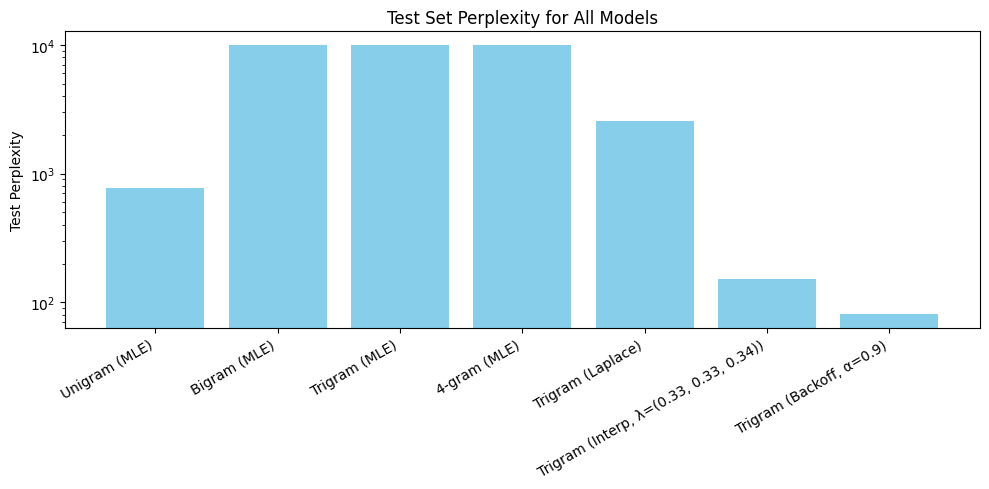

In [105]:
# Visualization: Bar plot of test set perplexities
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
labels = summary_df['Model']
values = [float(x) if x != 'INF' else 1e4 for x in summary_df['Test Perplexity']]
plt.bar(labels, values, color='skyblue')
plt.ylabel('Test Perplexity')
plt.title('Test Set Perplexity for All Models')
plt.xticks(rotation=30, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.show()

## 7. Text Generation from the Best Model

Generate sample sentences using the best performing model (lowest test perplexity among all models).

In [123]:
# Identify best model by lowest test perplexity
best_model_name = summary_df.loc[summary_df['Test Perplexity'].replace('INF', float('inf')).astype(float).idxmin(), 'Model']
print(f"Best model: {best_model_name}")

# Map model name to model object
def get_model_by_name(name):
    if 'Interp' in name:
        return interp_model
    elif 'Backoff' in name:
        return backoff_model
    elif 'Laplace' in name:
        return laplace_model
    elif '4-gram' in name:
        return NGramModel(4, train_tokens, vocab)
    elif '3-gram' in name:
        return NGramModel(3, train_tokens, vocab)
    elif '2-gram' in name:
        return NGramModel(2, train_tokens, vocab)
    elif 'Unigram' in name:
        return NGramModel(1, train_tokens, vocab)
    else:
        raise ValueError('Unknown model name')

best_model = get_model_by_name(best_model_name)

import random

def generate_sentence(model, n=3, min_len=18, max_len=20, renormalize=False):
    sent = ['<s>'] * (n - 1)
    
    for _ in range(max_len):
        context = tuple(sent[-(n - 1):]) if n > 1 else ()
        candidates, scores = [], []
        
        for w in model.vocab:
            ngram = context + (w,)
            s = model.ngram_prob(ngram)
            if s > 0:
                candidates.append(w)
                scores.append(s)
        
        if not candidates:
            break

        # Optional: renormalize weights so they sum to 1
        if renormalize:
            total = sum(scores)
            if total > 0:
                scores = [s / total for s in scores]
        
        w = random.choices(candidates, weights=scores, k=1)[0]
        sent.append(w)
        
        # stop only if we reach </s> *and* min length satisfied
        if w == '</s>' and len([tok for tok in sent if tok not in ['<s>', '</s>']]) >= min_len:
            break
    
    # ensure at least min_len words (if too short, force continuation)
    clean_sent = [w for w in sent if w not in ['<s>', '</s>']]
    if len(clean_sent) < min_len:
        extra_needed = min_len - len(clean_sent)
        for _ in range(extra_needed):
            context = tuple(sent[-(n - 1):]) if n > 1 else ()
            candidates, scores = [], []
            for w in model.vocab:
                ngram = context + (w,)
                s = model.ngram_prob(ngram)
                if s > 0:
                    candidates.append(w)
                    scores.append(s)
            if not candidates:
                break
            if renormalize:
                total = sum(scores)
                if total > 0:
                    scores = [s / total for s in scores]
            w = random.choices(candidates, weights=scores, k=1)[0]
            sent.append(w)
            if len([tok for tok in sent if tok not in ['<s>', '</s>']]) >= min_len:
                break
    
    return ' '.join([w for w in sent if w not in ['<s>', '</s>']])

# Generate 5 sentences
for i in range(5):
    print(f"Sentence {i+1}: {generate_sentence(best_model)}")

/var/folders/xc/95cxszfj1qq78vbjvgfwqh2m0000gn/T/ipykernel_38194/793963389.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  best_model_name = summary_df.loc[summary_df['Test Perplexity'].replace('INF', float('inf')).astype(float).idxmin(), 'Model']


Best model: Trigram (Backoff, α=0.9)
Sentence 1: richter of <unk> and engineers three arrest same risks that matter N to $ these two exposures and in response
Sentence 2: the notes also would institutions overseas a <unk> <unk> by phone be hard time <unk> assistant vice president and party
Sentence 3: and toledo plants current southern <unk> buddy nasdaq composite trading schering-plough comment he taken in should rely on
Sentence 4: at least as fast a N N the only safe to eight common shares system and the debt
Sentence 5: jay gould to continue exceeds $ that for <unk> in health and human services 's campaign comments to proposal looking
